Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.autograd import Variable
import shutil
from torchsummary import summary

import os
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

Hyperparameters

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.cuda.manual_seed(1337)

batch_size = 100
test_batch_size = 1000
gamma = 0.001
lr = 0.01
prune_rate=0.9

kwargs = {'num_workers': 16, 'pin_memory': True}

cuda


DataLoaders

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


Files already downloaded and verified


Network Model

In [4]:
class sequential_model(nn.Module):
    def __init__(self, layers=None):
        super(sequential_model, self).__init__()
        if layers == None:
            layers = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512]
        num_classes = 10
        self.feature = self.make_layers(layers)
        self.classifier = nn.Linear(layers[-1], num_classes)
    
    def make_layers(self, structure):
        layers = []
        in_channels = 3
        for v in structure:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1, bias=False)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.feature(x)
        x = nn.AvgPool2d(2)(x)
        x = x.view(x.size(0), -1)
        y = self.classifier(x)
        return y

Train Epoch method

In [5]:
def sum_scaling_factors(model):
    sum_channel_scaling_factors = 0
        
    #sum absolute value from all channel scaling factors for sparsity
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            sum_channel_scaling_factors += torch.sum(m.weight.data.abs())
    return sum_channel_scaling_factors

In [6]:
def train(model, epoch, optimizer, data_loader=train_loader, sparsity=True):
    model.train()
    #print(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        
        if sparsity:
            sum_channel_scaling_factors = sum_scaling_factors(model)
            loss = F.cross_entropy(output, target) + gamma * sum_channel_scaling_factors
        else:
            loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
            
        """if idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
            epoch, idx * len(data), len(data_loader.dataset),
            100. * idx / len(data_loader), loss.data.item()))"""

Validation Method

In [7]:
#returns precision and loss of model
def test(model, data_loader=test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)        
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        test_loss /= len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return (correct / float(len(data_loader.dataset)), test_loss)

Save Model Method

In [8]:
def save_checkpoint(state, is_best, filename='model_best'):
    torch.save(state, filename + '_checkpoint.pth.tar')
    if is_best:
        shutil.copyfile(filename + '_checkpoint.pth.tar', filename + '.pth.tar')

Train network method

In [9]:
def train_model(model, epochs=10, sparsity=True, filename='best_model'):
    
    model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_prec = 0.
    for i in range(0, epochs):
        train(model, i, optimizer, sparsity=sparsity)
        prec, loss = test(model)
        is_best = prec > best_prec
        best_prec1 = max(prec, best_prec)
        save_checkpoint({
            'epoch': i + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec,
            'optimizer': optimizer.state_dict(),
        }, is_best, filename)
    return model

Load existing Model method

In [10]:
def load_model(checkpoint_path="checkpoint_sr.pth.tar", model_path="model_best_sr.pth.tar"):
    model = sequential_model()
    model.cuda()
    if os.path.isfile(model_path):
        print("=> loading checkpoint '{}'".format(model_path))
        checkpoint_path = torch.load(model_path)
        best_prec1 = checkpoint_path['best_prec1']
        model.load_state_dict(checkpoint_path['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(model, checkpoint_path['epoch'], best_prec1))
    else:
        print("=> no checkpoint found at")
    return model

Select weak channels

In [11]:
def selectChannels(model, percent=0.2):
    total = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            total += m.weight.data.shape[0]

    bn = torch.zeros(total)
    index = 0
    #print("Typ:")
    #print(type(model.modules()))
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            size = m.weight.data.shape[0]
            bn[index:(index+size)] = m.weight.data.abs().clone()
            index += size

    y, i = torch.sort(bn)
    thre_index = int(total * percent)
    thre = y[thre_index]

    pruned = 0
    cfg = []
    cfg_mask = []
    for k, m in enumerate(model.modules()):
        if isinstance(m, nn.BatchNorm2d):
            weight_copy = m.weight.data.clone()
            #print(type(weight_copy.abs().gt(thre).float()))
            #mask is a matrix in which 1 marks the channels which are kept and 0 marks the pruned channels
            mask = weight_copy.abs().gt(thre).float().cuda()          
            #pruned is the number of all pruned channels 
            pruned = pruned + mask.shape[0] - torch.sum(mask)
            m.weight.data.mul_(mask)
            m.bias.data.mul_(mask)
            cfg.append(int(torch.sum(mask)))
            cfg_mask.append(mask.clone())
            #print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
            #    format(k, mask.shape[0], int(torch.sum(mask))))
        elif isinstance(m, nn.MaxPool2d):
            cfg.append('M')
    return cfg, cfg_mask

In [12]:
"""
Takes a smaller network structure in which the model is transfered.
cfg_mask marks all parameters over model which are transfered or dropped
"""
def transfer_params(cfg, cfg_mask, model):
    filtered_cfg = []
    #remove all layers with zero or one channel
    for elem in cfg:
        if type(elem) is int and elem > 1:
            filtered_cfg.append(elem)
        elif type(elem) is str:
            filtered_cfg.append(elem)
    cfg = filtered_cfg
    
    
    newmodel = sequential_model(layers=cfg)
    newmodel.cuda() 

    layer_id_in_cfg = 0
    start_mask = torch.ones(3)
    end_mask = cfg_mask[layer_id_in_cfg]
    skip_linear = False
    
    parameters = newmodel.modules()
    layer = next(parameters)
    layer = next(parameters)
    layer = next(parameters)
    skip_next = 0
    for m0 in model.modules(): 
        if isinstance(layer, nn.MaxPool2d):
            layer = next(parameters)
        if skip_next > 0:
            skip_next -= 1
            continue
        if isinstance(m0, nn.BatchNorm2d):
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            layer.weight.data = m0.weight.data[idx1].clone()
            layer.bias.data = m0.bias.data[idx1].clone()
            layer.running_mean = m0.running_mean[idx1].clone()
            layer.running_var = m0.running_var[idx1].clone()
            layer_id_in_cfg += 1
            start_mask = end_mask.clone()
            if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                end_mask = cfg_mask[layer_id_in_cfg]
            layer = next(parameters)
        elif isinstance(m0, nn.Conv2d):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            if np.size(idx1) <= 1: 
                skip_next = 2
                layer_id_in_cfg += 1
                if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                    end_mask = cfg_mask[layer_id_in_cfg]
                continue
            #print('In shape: {:d} Out shape:{:d}'.format(idx0.shape[0], idx1.shape[0]))
            w = m0.weight.data[:, idx0, :, :].clone()
            w = w[idx1, :, :, :].clone()
            layer.weight.data = w.clone()
            layer = next(parameters)
            # m1.bias.data = m0.bias.data[idx1].clone()
        elif isinstance(m0, nn.Linear):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            layer.weight.data = m0.weight.data[:, idx0].clone()      
            #layer = next(parameters)
        elif isinstance(m0, nn.ReLU):
            layer = next(parameters)
        
    return newmodel

In [13]:
def prune_model(model, percent=0.3):
    cfg, cfg_mask = selectChannels(model, percent)
    #print(cfg)
    prune_model = transfer_params(cfg, cfg_mask, model)
    torch.save({'cfg': cfg, 'state_dict': prune_model.state_dict()}, f='pruned_model.pt')
    return prune_model

In [14]:
model_sparsity = train_model(sequential_model(), epochs=10, sparsity=True, filename='epochs10_sparsity')
#model = train_model(sequential_model(), epochs=10, sparsity=False, filename='epochs10_no_sparsity')
#model = load_model(checkpoint_path="epochs10_sparsity.pth.tar", model_path="epochs10_sparsity_checkpoint.pth.tar")

/home/eddy/Programme/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1496, Accuracy: 4747/10000 (47.5%)


Test set: Average loss: 0.0973, Accuracy: 6468/10000 (64.7%)


Test set: Average loss: 0.0815, Accuracy: 7127/10000 (71.3%)


Test set: Average loss: 0.0839, Accuracy: 7079/10000 (70.8%)


Test set: Average loss: 0.0631, Accuracy: 7968/10000 (79.7%)


Test set: Average loss: 0.0654, Accuracy: 7935/10000 (79.3%)


Test set: Average loss: 0.0498, Accuracy: 8252/10000 (82.5%)


Test set: Average loss: 0.0507, Accuracy: 8416/10000 (84.2%)


Test set: Average loss: 0.0436, Accuracy: 8600/10000 (86.0%)


Test set: Average loss: 0.0437, Accuracy: 8391/10000 (83.9%)



In [15]:
model_list = []
fine_tune_epochs = 3
steps = 20
for i in range(1, steps):
    print("Pruning ratio: " + str(i/steps))
    raw_pruned = prune_model(model_sparsity, i/steps)
    test_error = float(test(raw_pruned)[0])
    fine_tuned = train_model(raw_pruned, epochs=fine_tune_epochs)
    test_error_fine_tuned = float(test(fine_tuned)[0])
    model_list.append({'model': fine_tuned, 'test_error': test_error, 
                       'fine_tuned_error': test_error_fine_tuned, 'prune_ratio': i/steps, 
                       'fine_tune_epochs': fine_tune_epochs})


Pruning ratio: 0.05

Test set: Average loss: 0.0488, Accuracy: 8283/10000 (82.8%)


Test set: Average loss: 0.0495, Accuracy: 8445/10000 (84.4%)


Test set: Average loss: 0.0398, Accuracy: 8498/10000 (85.0%)


Test set: Average loss: 0.0359, Accuracy: 8686/10000 (86.9%)


Test set: Average loss: 0.0371, Accuracy: 8686/10000 (86.9%)

Pruning ratio: 0.1

Test set: Average loss: 0.0520, Accuracy: 8171/10000 (81.7%)


Test set: Average loss: 0.0398, Accuracy: 8640/10000 (86.4%)


Test set: Average loss: 0.0436, Accuracy: 8576/10000 (85.8%)


Test set: Average loss: 0.0395, Accuracy: 8712/10000 (87.1%)


Test set: Average loss: 0.0452, Accuracy: 8712/10000 (87.1%)

Pruning ratio: 0.15

Test set: Average loss: 0.0671, Accuracy: 7887/10000 (78.9%)


Test set: Average loss: 0.0443, Accuracy: 8599/10000 (86.0%)


Test set: Average loss: 0.0392, Accuracy: 8689/10000 (86.9%)


Test set: Average loss: 0.0385, Accuracy: 8729/10000 (87.3%)


Test set: Average loss: 0.0413, Accuracy: 8729/10000 (87.3

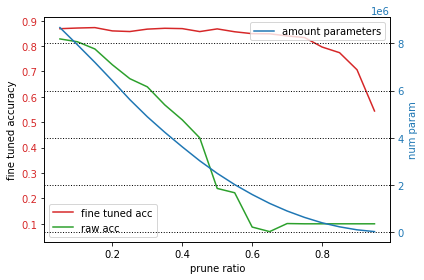

In [16]:
test_error = []
fine_tuned_error = []
prune_ratio = []
num_parameters = []
for prune_set in model_list:
    test_error.append(prune_set['test_error'])
    fine_tuned_error.append(prune_set['fine_tuned_error'])
    prune_ratio.append(prune_set['prune_ratio'])
    num_parameters.append(sum(p.numel() for p in prune_set['model'].parameters()))


fig, ax1 = plt.subplots()    

color = 'tab:red'
ax1.plot(prune_ratio, fine_tuned_error, color='tab:red', label='fine tuned acc')
ax1.plot(prune_ratio, test_error, color='tab:green', label='raw acc')
ax1.set_xlabel('prune ratio')
ax1.set_ylabel('fine tuned accuracy')
ax1.tick_params(axis='y', labelcolor=color)

plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('num param', color=color)  # we already handled the x-label with ax1
ax2.plot(prune_ratio, num_parameters, color=color, label='amount parameters')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('linear')
plt.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(axis='both', color='black', linestyle=':', linewidth=1)
plt.show()


In [17]:
result = zip(prune_ratio, num_parameters, fine_tuned_error)
for ratio, num, err in result:
    print('ratio: {:f}, error: {:f}, param:{:d}'.format(ratio, err, num))

ratio: 0.050000, error: 0.868600, param:8673056
ratio: 0.100000, error: 0.871200, param:7944759
ratio: 0.150000, error: 0.872900, param:7200206
ratio: 0.200000, error: 0.859900, param:6420955
ratio: 0.250000, error: 0.857400, param:5621432
ratio: 0.300000, error: 0.866900, param:4895456
ratio: 0.350000, error: 0.870200, param:4237786
ratio: 0.400000, error: 0.868900, param:3620774
ratio: 0.450000, error: 0.857200, param:3029760
ratio: 0.500000, error: 0.867800, param:2497572
ratio: 0.550000, error: 0.856500, param:2021254
ratio: 0.600000, error: 0.849000, param:1601400
ratio: 0.650000, error: 0.848500, param:1224700
ratio: 0.700000, error: 0.840200, param:902460
ratio: 0.750000, error: 0.833700, param:630313
ratio: 0.800000, error: 0.796400, param:402879
ratio: 0.850000, error: 0.774100, param:231933
ratio: 0.900000, error: 0.706800, param:105632
ratio: 0.950000, error: 0.544400, param:29856


In [18]:
"""safed = torch.load('pruned_model.pt')
structure = safed['cfg']
weights = safed['state_dict']
pruned_model = sequential_model(structure)
pruned_model.load_state_dict(weights)
pruned_model.cuda()
prec, loss = test(pruned_model)"""

"safed = torch.load('pruned_model.pt')\nstructure = safed['cfg']\nweights = safed['state_dict']\npruned_model = sequential_model(structure)\npruned_model.load_state_dict(weights)\npruned_model.cuda()\nprec, loss = test(pruned_model)"

In [19]:
summary(model_list[18]['model'], (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 32, 32]             189
       BatchNorm2d-2            [-1, 7, 32, 32]              14
              ReLU-3            [-1, 7, 32, 32]               0
            Conv2d-4            [-1, 3, 32, 32]             189
       BatchNorm2d-5            [-1, 3, 32, 32]               6
              ReLU-6            [-1, 3, 32, 32]               0
         MaxPool2d-7            [-1, 3, 16, 16]               0
            Conv2d-8            [-1, 4, 16, 16]             108
       BatchNorm2d-9            [-1, 4, 16, 16]               8
             ReLU-10            [-1, 4, 16, 16]               0
           Conv2d-11            [-1, 3, 16, 16]             108
      BatchNorm2d-12            [-1, 3, 16, 16]               6
             ReLU-13            [-1, 3, 16, 16]               0
        MaxPool2d-14              [-1, 